In [1]:
import pathlib
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
validation_path = pathlib.Path("/work/scratch-nopw2/wkjones/validation_filtered/")
files = sorted(list(validation_path.glob("validation_dccs_*_120000_E*_120000_X0000_2500_Y0000_1500.nc")))
print(len(files))

321


In [3]:
stats_path = pathlib.Path("/work/scratch-nopw2/wkjones/statistics/")

In [4]:
flash2core = []
flash2anvil = []
core2flash = []
anvil2flash = []

for f in files:
    print(f, end='\r')
    with xr.open_dataset(f) as ds:
        start_str = f.stem.split("_S")[-1][:15]
        end_str = f.stem.split("_E")[-1][:15]
        x_str = f.stem.split("_X")[-1][:9]
        y_str = f.stem.split("_Y")[-1][:9]
        stats_file = list(
            stats_path.glob(
                f"dcc_statistics_G16_S{start_str[:6]}*_X{x_str}_Y{y_str}.nc"
            )
        )[0]
        
        with xr.open_dataset(stats_file) as stats_ds:
            core_in_anvil = np.isin(ds.core.data, stats_ds.core.data[stats_ds.core_has_anvil_flag.data])
            flash2core.append(ds.flash_core_distance.data)
            flash2anvil.append(ds.flash_anvil_distance.data)
            wh_core = np.logical_and(ds.core_margin_flag.data, core_in_anvil)
            core2flash.append(ds.core_glm_distance.loc[wh_core])
            anvil2flash.append(ds.anvil_glm_distance.data[ds.anvil_margin_flag.data])

flash2core = np.concatenate(flash2core)
flash2anvil = np.concatenate(flash2anvil)
core2flash = np.concatenate(core2flash)
anvil2flash = np.concatenate(anvil2flash)

flash2core = flash2core[np.isfinite(flash2core)]
flash2anvil = flash2anvil[np.isfinite(flash2anvil)]
core2flash = core2flash[np.isfinite(core2flash)]
anvil2flash = anvil2flash[np.isfinite(anvil2flash)]

n_glm = flash2core.size
n_core = core2flash.size
n_anvil = anvil2flash.size


In [5]:
core2flash.max()

2178.2952

In [6]:
# print(n_glm, n_core, n_wvd, n_anvil)
print(n_glm, n_core, n_anvil)

117332965 345638 90414


In [7]:
core_pod = np.sum(flash2core<=10)/flash2core.size
anvil_pod = np.sum(flash2anvil<=10)/flash2anvil.size
print("core pod:", core_pod, "anvil pod:", anvil_pod)

core_far = np.sum(core2flash>10)/n_core
anvil_far = np.sum(anvil2flash>10)/n_anvil

print("core far:", core_far, "anvil_far", anvil_far)

core_f1 = 2*core_pod*(1-core_far)/(core_pod+1-core_far)
anvil_f1 = 2*anvil_pod*(1-anvil_far)/(anvil_pod+1-anvil_far)

print("core f1:", core_f1, "anvil f1:", anvil_f1)

core pod: 0.6580192105432604 anvil pod: 0.33412755272819605
core far: 0.19905508074922318 anvil_far 0.16666666666666666
core f1: 0.7224812902404033 anvil f1: 0.47700035281322817


In [8]:
validation_ds = xr.Dataset(
    data_vars=dict(
        flash_core_distance=(('flash_core',), flash2core), 
        flash_anvil_distance=(('flash_anvil',), flash2anvil), 
        core_flash_distance=(('core',), core2flash), 
        anvil_flash_distance=(('anvil',), anvil2flash), 
        core_pod=(tuple(), core_pod), 
        anvil_pod=(tuple(), anvil_pod), 
        core_far=(tuple(), core_far), 
        anvil_far=(tuple(), anvil_far), 
        core_f1=(tuple(), core_f1), 
        anvil_f1=(tuple(), anvil_f1), 
        n_glm=(tuple(), n_glm), 
        n_core=(tuple(), n_core), 
        n_anvil=(tuple(), n_anvil), 
        )
    )
# validation_ds.to_netcdf('./data/validation_data.nc')

In [9]:
core_pod_hist = np.histogram(validation_ds.flash_core_distance, bins=40, range=[0,40])[0] / validation_ds.n_glm.data
anvil_pod_hist = np.histogram(validation_ds.flash_anvil_distance, bins=40, range=[0,40])[0] / validation_ds.n_glm.data

core_far_hist = np.histogram(validation_ds.core_flash_distance, bins=40, range=[0,40])[0] / validation_ds.n_core.data
anvil_far_hist = np.histogram(validation_ds.anvil_flash_distance, bins=40, range=[0,40])[0] / validation_ds.n_anvil.data


markers:
n = 345638
POD = 0.6580192105432604
FAR = 0.19905508074922318
F1 score = 0.7224812902404033
anvil:
n = 90414
POD = 0.33412755272819605
FAR = 0.16666666666666666
F1 score = 0.47700035281322817
total GLM flashes:  117332965


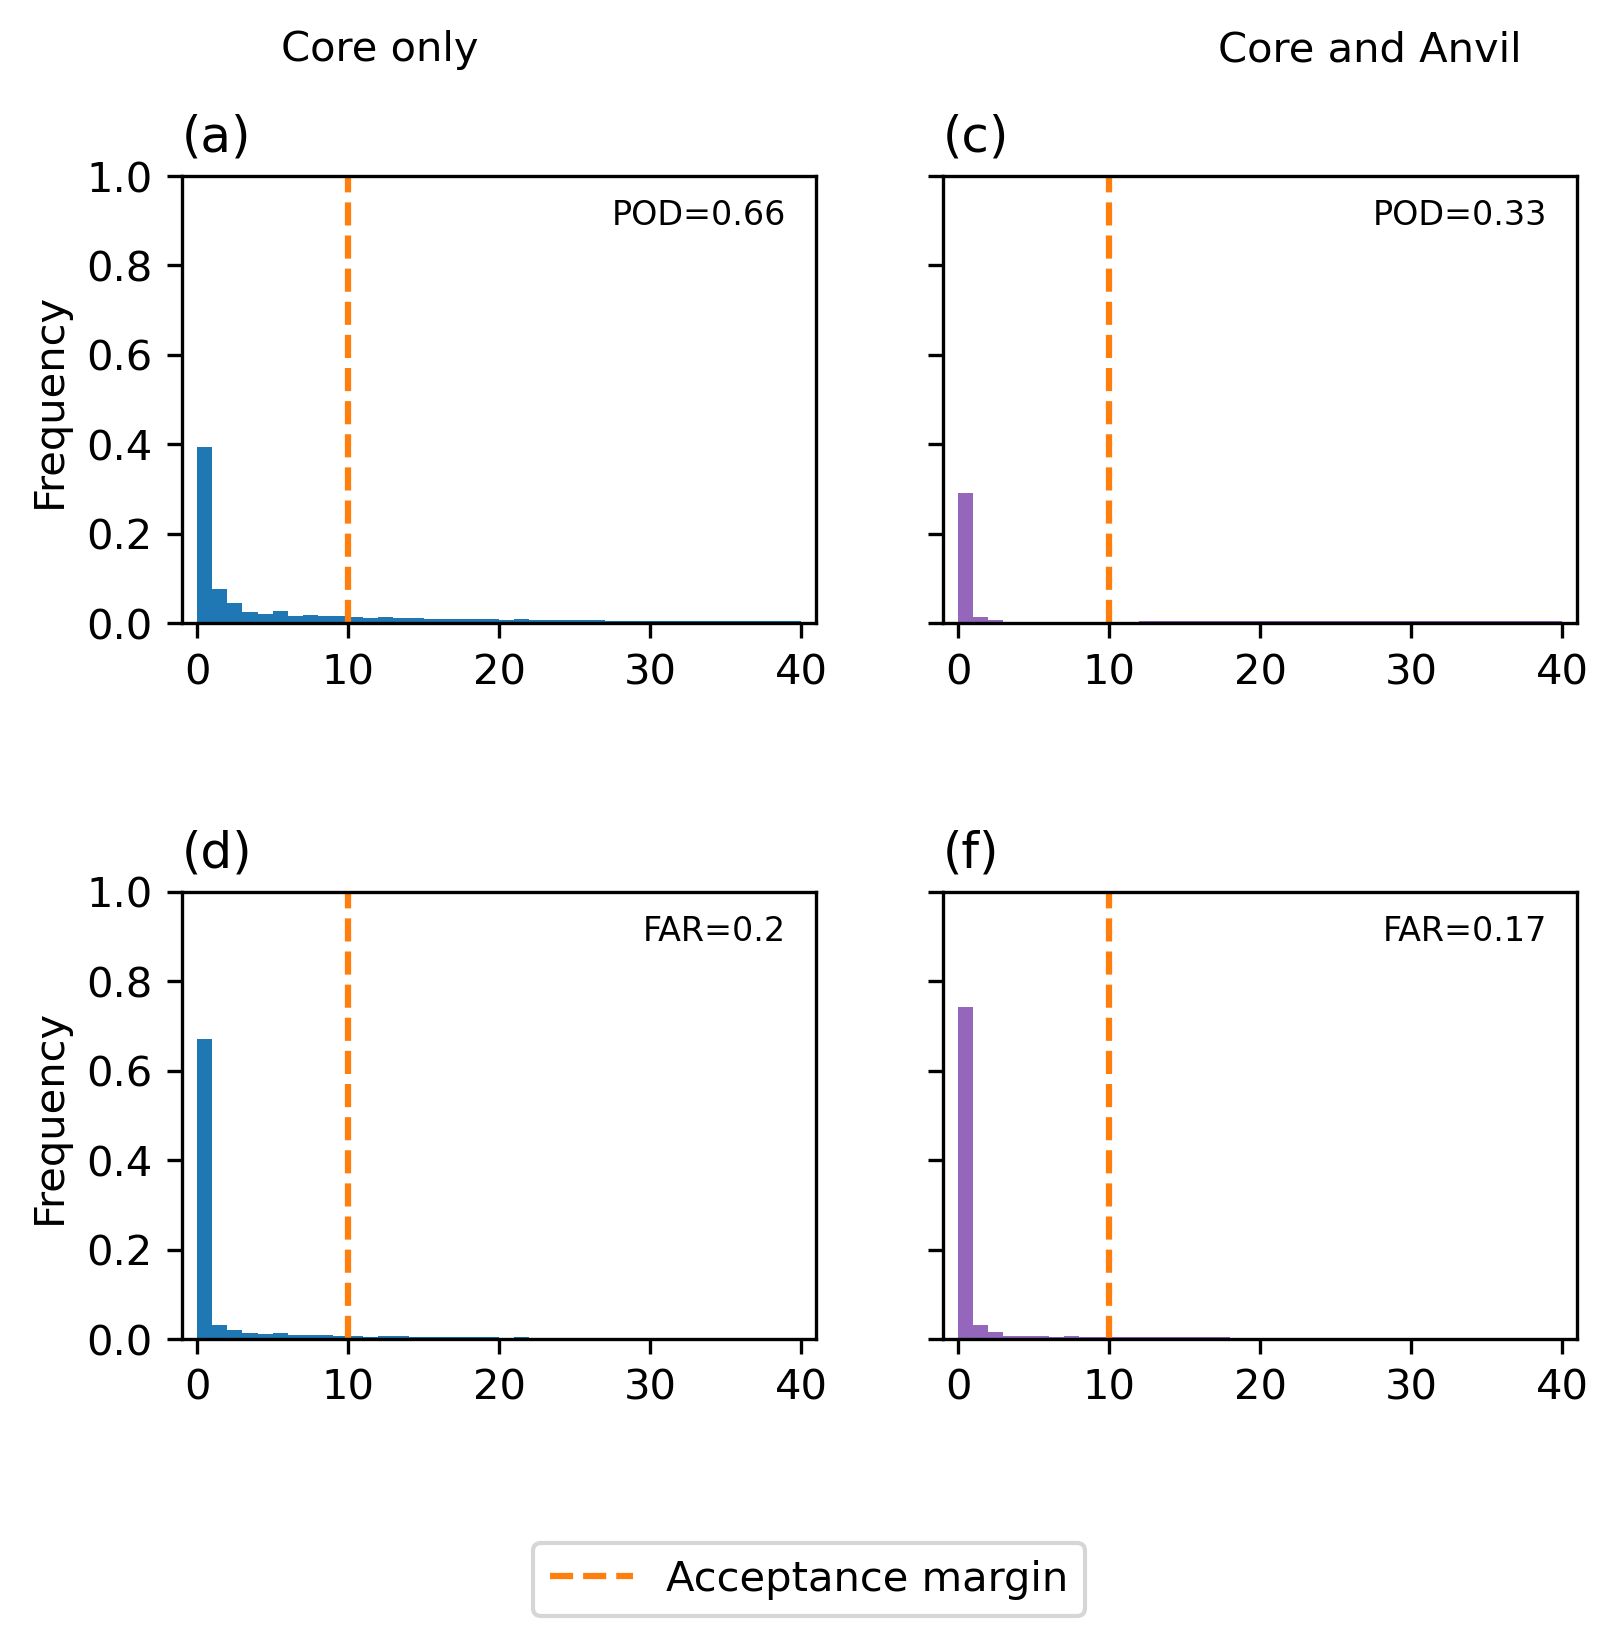

In [10]:
acceptance_margin = 10

fig = plt.figure(dpi=300, figsize=(6,5.5))

plt.subplot(221)
plt.bar(np.arange(0,40), core_pod_hist,
        width=1, align='edge')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('(a)', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')
plt.text(39,0.95,'POD='+str(np.round(validation_ds.core_pod.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

# plt.subplot(232)
# plt.bar(np.arange(0,40), wvd_pod_hist,
#         width=1, align='edge', color='C02')
# plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# # plt.title('GLM flash distance to WVD')
# plt.title('(b)', loc='left')
# # plt.ylabel('Frequency')
# plt.ylim([0,1.0])
# plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
# plt.xlim([-1,41])
# plt.xlabel('Distance to detected object (pixels)')
# plt.text(39,0.95,
#          'POD='+str(np.round(validation_ds.wvd_pod.data,2)), 
#          horizontalalignment='right', verticalalignment='top',
#          fontsize=8)

plt.subplot(222)
plt.bar(np.arange(0,40), anvil_pod_hist,
        width=1, align='edge', color='C04')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest anvil')
plt.title('(c)', loc='left')
# plt.ylabel('Frequency')
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to detected anvil (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(validation_ds.anvil_pod.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(223)
plt.bar(np.arange(0,40), core_far_hist,
        width=1, align='edge', color='C00')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('(d)', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(validation_ds.core_far.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)


# plt.subplot(235)
# plt.bar(np.arange(0,40), wvd_far_hist,
#         width=1, align='edge', color='C02')
# plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# # plt.title('WVD distance to nearest GLM flash')
# plt.title('(e)', loc='left')
# # plt.ylabel('Frequency')
# plt.ylim([0,1.0])
# plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
# plt.xlim([-1,41])
# plt.xlabel('Distance to nearest GLM flash (pixels)')
# plt.text(39,0.95,
#          'FAR='+str(np.round(validation_ds.wvd_far.data,2)), 
#          horizontalalignment='right', verticalalignment='top',
#          fontsize=8)

plt.subplot(224)
plt.bar(np.arange(0,40), anvil_far_hist,
        width=1, align='edge', color='C04')
plt.plot([acceptance_margin,acceptance_margin],[0,1],c='C01',linestyle='--')
# plt.title('Anvil distance to nearest GLM flash')
plt.title('(f)', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(validation_ds.anvil_far.data,2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Acceptance margin'], loc='lower center')

fig.text(0.235, 0.95, 'Core only', ha='center', va='baseline')
# fig.text(0.515, 0.95, 'Anvil only', ha='center', va='baseline')
fig.text(0.785, 0.95, 'Core and Anvil', ha='center', va='baseline')


# plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.85, left=0.075, right=0.95)
plt.subplots_adjust(hspace=0.6, bottom=0.175)

print('markers:')
print('n =', validation_ds.n_core.data)
print('POD =', validation_ds.core_pod.data)
print('FAR =', validation_ds.core_far.data)
print('F1 score =', validation_ds.core_f1.data)

# print('WVD:')
# print('n =', validation_ds.n_wvd.data)
# print('POD =', validation_ds.wvd_pod.data)
# print('FAR =', validation_ds.wvd_far.data)
# print('F1 score =', validation_ds.wvd_f1.data)

print('anvil:')
print('n =', validation_ds.n_anvil.data)
print('POD =', validation_ds.anvil_pod.data)
print('FAR =', validation_ds.anvil_far.data)
print('F1 score =', validation_ds.anvil_f1.data)

print('total GLM flashes: ', int(validation_ds.n_glm.data))


In [11]:
validation_ds.close()

In [12]:
ds

<xarray.Dataset>
Dimensions:               (core: 2261, anvil: 20, flash: 822)
Coordinates:
  * core                  (core) int32 76999 77069 77108 ... 79731 79732 79733
  * anvil                 (anvil) int32 5301 5304 5308 5325 ... 5385 5387 5395
Dimensions without coordinates: flash
Data variables: (12/13)
    flash_core_distance   (flash) float32 13.6 30.36 33.53 ... 73.98 159.4 91.0
    flash_anvil_distance  (flash) float32 27.31 25.5 27.17 25.5 ... inf inf inf
    flash_count           int32 ...
    anvil_glm_distance    (anvil) float32 582.8 567.9 0.0 ... 95.13 0.0 131.0
    anvil_margin_flag     (anvil) bool False False False True ... True True True
    anvil_pod             float32 ...
    ...                    ...
    anvil_count           int32 ...
    core_glm_distance     (core) float32 ...
    core_margin_flag      (core) bool False False False ... False False False
    core_pod              float32 ...
    core_far              float32 ...
    core_count            int32 ...